In [21]:
%matplotlib notebook

import pandas as pd
import numpy as np
import sqlite3
from datetime import date
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

plt.style.use('seaborn-white')

In [22]:
# This data set contains information related to European soccer over the period 2008-2016.
# I decided to investigate Sunderland AFC. I was curious about how the different seasons 
# compared and also about performance over stages of the seasons.
# The data comes from Hugo Mathien in the form of a SQLlite file. 
# It is available at the following site: https://www.kaggle.com/hugomathien/soccer

In [23]:
# Load the data. If you wish to perform your own analysis change the database location 
# to wherever you downloaded the file to.

database_loc = r"C:\Users\me\Documents\datasets\database.sqlite"
con = sqlite3.connect(database_loc)

In [24]:
query = "SELECT name FROM sqlite_master WHERE type='table';"
print (pd.read_sql(query, con))

              name
0          Country
1  sqlite_sequence
2           League
3            Match
4           Player
5     Player_Stats
6             Team


In [25]:
# Let's save the team table as a panda's DF then find Sunderland's ID information.

query = "SELECT * FROM Team;"
team = pd.read_sql(query, con)
team.head()

,id,team_api_id,team_long_name,team_short_name
0,1,9987,Genk,GEN
1,2,9993,Beerschot AC,BAC
2,3,10000,Zulte-Waregem,ZUL
3,4,9994,Lokeren,LOK
4,5,9984,Cercle Bruges,CEB


In [26]:
team.loc[team['team_long_name'] == 'Sunderland']

,id,team_api_id,team_long_name,team_short_name
29,3461,8472,Sunderland,SUN


In [27]:
# Not let's load in the match table as a dataframe and inspect it.

query = "SELECT * FROM Match;"
match = pd.read_sql(query, con)
match.head()

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,...,SJA,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA
0,1,1,1,2008/2009,1,2008-08-17 00:00:00,492473,9987,9993,1,...,4.00,1.65,3.40,4.50,1.78,3.25,4.00,1.73,3.40,4.20
1,2,1,1,2008/2009,1,2008-08-16 00:00:00,492474,10000,9994,0,...,3.80,2.00,3.25,3.25,1.85,3.25,3.75,1.91,3.25,3.60
2,3,1,1,2008/2009,1,2008-08-16 00:00:00,492475,9984,8635,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,1,1,2008/2009,1,2008-08-17 00:00:00,492476,9991,9998,5,...,7.50,1.45,3.75,6.50,1.50,3.75,5.50,1.44,3.75,6.50
4,5,1,1,2008/2009,1,2008-08-16 00:00:00,492477,7947,9985,1,...,1.73,4.50,3.40,1.65,4.50,3.50,1.65,4.75,3.30,1.67


In [28]:
# The DF reveals that of the two ID's shown above the one we will need for interacting with
# this DF is the team_api_id (in Sunderland's case this is 8472).
# There is a bounty of data here including goals, odds, stage of the season etc.
# We can also see some NaNs in the third row which is something to bear in mind.
# For the purposes of my analysis I slimmed the DF down to contain the columns I was 
# interested in. After that I modified the DF to only contain Sunderland matches.  
# As one would expect this significantly reduces the size of the DF.

wanted_columns = ['home_team_api_id', 'away_team_api_id', 'season', 'stage',
                  'date', 'home_team_goal', 'away_team_goal']

df = pd.DataFrame(data=match, columns=wanted_columns)
print(len(df))
df = df[(df.home_team_api_id==8472) | (df.away_team_api_id==8472)]
print(len(df))
df.head()

25945
301


,home_team_api_id,away_team_api_id,season,stage,date,home_team_goal,away_team_goal
1730,8472,8650,2008/2009,1,2008-08-16 00:00:00,0,1
1743,10194,8472,2008/2009,10,2008-10-29 00:00:00,1,0
1757,8455,8472,2008/2009,11,2008-11-01 00:00:00,5,0
1760,8472,8462,2008/2009,12,2008-11-08 00:00:00,1,2
1773,8655,8472,2008/2009,13,2008-11-15 00:00:00,1,2


In [29]:
# The final number is actually a cause for concern. The period covers 8 seasons and a 
# season lasts 38 matches. We should have a DF of size 304. 
# There is therefore missing data and we'll tackle this later.

In [30]:
# Let's check for any null data that could throw a spanner in the works of our analysis.

null_index = pd.isnull(df).any(1).nonzero()[0]
null_index

array([], dtype=int64)

In [31]:
# Thankfully there isn't any null data in our dataframe and we can move on.
# Let's tidy up the date column. Then we'll use it to sort the DF.

date = pd.to_datetime(df['date'])
df = df.drop('date', axis=1)
df.insert(3, 'date', date)

df.sort_values(['date'], ascending=[True], inplace=True)
df.head()

,home_team_api_id,away_team_api_id,season,date,stage,home_team_goal,away_team_goal
1730,8472,8650,2008/2009,2008-08-16,1,0,1
1839,8586,8472,2008/2009,2008-08-23,2,1,2
1950,8472,8456,2008/2009,2008-08-31,3,0,3
2057,8528,8472,2008/2009,2008-09-13,4,1,1
2059,8472,8549,2008/2009,2008-09-20,5,2,0


In [32]:
# I'll create functions to calculate results and points earned.

In [33]:
def result(row, team_api_id):
    if (row['home_team_goal']>row['away_team_goal']) and \
       row['home_team_api_id']==team_api_id:
        return 'HW'
    if (row['home_team_goal']>row['away_team_goal']) and \
       row['home_team_api_id']!=team_api_id:
        return 'AL'
    if row['home_team_goal']==row['away_team_goal'] and \
       row['home_team_api_id']==team_api_id:       
        return 'HD'
    if row['home_team_goal']==row['away_team_goal'] and \
       row['home_team_api_id']!=team_api_id:       
        return 'AD'
    if (row['home_team_goal']<row['away_team_goal']) and \
       row['home_team_api_id']==team_api_id:
        return 'HL'
    if (row['home_team_goal']<row['away_team_goal']) and \
       row['home_team_api_id']!=team_api_id:
        return 'AW' 

In [34]:
def point(row):
    win = ['HW', 'AW']
    draw = ['HD', 'AD']    
    if row['result'] in win:
        return 3
    elif row['result'] in draw:
        return 1
    else:
        return 0

In [35]:
# Now let's apply these functions on our DF.
df['result'] = df.apply(lambda row: result(row, 8472), axis=1)
df['points'] = df.apply(lambda row: point(row), axis=1)
df.head()

,home_team_api_id,away_team_api_id,season,date,stage,home_team_goal,away_team_goal,result,points
1730,8472,8650,2008/2009,2008-08-16,1,0,1,HL,0
1839,8586,8472,2008/2009,2008-08-23,2,1,2,AW,3
1950,8472,8456,2008/2009,2008-08-31,3,0,3,HL,0
2057,8528,8472,2008/2009,2008-09-13,4,1,1,AD,1
2059,8472,8549,2008/2009,2008-09-20,5,2,0,HW,3


In [36]:
# For aesthetic reasons I'll reindex the DF.

df_len = len(df) + 1
df = df.set_index(np.arange(1,df_len))
df.head()

,home_team_api_id,away_team_api_id,season,date,stage,home_team_goal,away_team_goal,result,points
1,8472,8650,2008/2009,2008-08-16,1,0,1,HL,0
2,8586,8472,2008/2009,2008-08-23,2,1,2,AW,3
3,8472,8456,2008/2009,2008-08-31,3,0,3,HL,0
4,8528,8472,2008/2009,2008-09-13,4,1,1,AD,1
5,8472,8549,2008/2009,2008-09-20,5,2,0,HW,3


In [37]:
# Let's split up the DF into individual season DFs.

twenty_8 = df[df['season']=='2008/2009']
twenty_8 = twenty_8.set_index(np.arange(1,39))
twenty_9 = df[df['season']=='2009/2010']
twenty_9 = twenty_9.set_index(np.arange(1,39))
twenty_10 = df[df['season']=='2010/2011']
twenty_10 = twenty_10.set_index(np.arange(1,39))
twenty_11 = df[df['season']=='2011/2012']
twenty_11 = twenty_11.set_index(np.arange(1,39))
twenty_12 = df[df['season']=='2012/2013']
twenty_12 = twenty_12.set_index(np.arange(1,39))
twenty_13 = df[df['season']=='2013/2014']
twenty_13 = twenty_13.set_index(np.arange(1,39))
twenty_14 = df[df['season']=='2014/2015']
twenty_14 = twenty_14.set_index(np.arange(1,39))
twenty_15 = df[df['season']=='2015/2016']
twenty_15 = twenty_14.set_index(np.arange(1,39))

ValueError: Length mismatch: Expected axis has 35 elements, new values have 38 elements

In [38]:
# The code above yields the ValueError : Length mismatch: 
# Expected axis has 35 elements, new values have 38 elements.
# This is where our missing three matches should be! The 2011/2012 season. 

twenty_11.tail(10)

,home_team_api_id,away_team_api_id,season,date,stage,home_team_goal,away_team_goal,result,points
140,8659,8472,2011/2012,2012-02-25,26,4,0,AL,0
141,10261,8472,2011/2012,2012-03-04,27,1,1,AD,1
142,8472,8650,2011/2012,2012-03-10,28,1,0,HW,3
143,8655,8472,2011/2012,2012-03-20,29,2,0,AL,0
144,8472,8586,2011/2012,2012-04-07,32,0,0,HD,1
145,8472,8602,2011/2012,2012-04-14,34,0,0,HD,1
146,10252,8472,2011/2012,2012-04-21,35,0,0,AD,1
147,8472,8559,2011/2012,2012-04-28,36,2,2,HD,1
148,9879,8472,2011/2012,2012-05-06,37,2,1,AL,0
149,8472,10260,2011/2012,2012-05-13,38,0,1,HL,0


In [39]:
# Looking above shows that the missing matches are from stages 30, 31 and 33.
# In order to get the missing data into the table I manually looked up the data using wikipedia
# inputing them to a csv file titled missing data. 
# To add the missing data we can append a DF of the missing data to the original data.
# The date column got messed up after appending the missing_df. The steps taken to rectify
# this are shown below.

twenty_11 = df[df['season']=='2011/2012']
twenty_11 = twenty_11.set_index(np.arange(1,36))

missing_data = r"C:\Users\me\Documents\datasets\missing_data.csv"
missing_df = pd.read_csv(missing_data, names=twenty_11.columns)
missing_df = missing_df.set_index([[30, 31, 33]])
twenty_11 = twenty_11.append(missing_df)
twenty_11 = twenty_11.set_index(np.arange(1,39))
twenty_11.head()


,home_team_api_id,away_team_api_id,season,date,stage,home_team_goal,away_team_goal,result,points
1,8650,8472.0,2011/2012,2011-08-13 00:00:00,1,1,1,AD,1
2,8472,10261.0,2011/2012,2011-08-20 00:00:00,2,0,1,HL,0
3,10003,8472.0,2011/2012,2011-08-27 00:00:00,3,0,0,AD,1
4,8472,8455.0,2011/2012,2011-09-10 00:00:00,4,1,2,HL,0
5,8472,10194.0,2011/2012,2011-09-18 00:00:00,5,4,0,HW,3


In [40]:
# Now the 2011/12 season is fixed we can move on to the remaining seasons.

twenty_12 = df[df['season']=='2012/2013']
twenty_12 = twenty_12.set_index(np.arange(1,39))
twenty_13 = df[df['season']=='2013/2014']
twenty_13 = twenty_13.set_index(np.arange(1,39))
twenty_14 = df[df['season']=='2014/2015']
twenty_14 = twenty_14.set_index(np.arange(1,39))
twenty_15 = df[df['season']=='2015/2016']
twenty_15 = twenty_14.set_index(np.arange(1,39))
twenty_14.head(3)

,home_team_api_id,away_team_api_id,season,date,stage,home_team_goal,away_team_goal,result,points
1,8659,8472,2014/2015,2014-08-16,1,2,2,AD,1
2,8472,10260,2014/2015,2014-08-24,2,1,1,HD,1
3,10172,8472,2014/2015,2014-08-30,3,1,0,AL,0


In [41]:
twenty_15.head(3)

,home_team_api_id,away_team_api_id,season,date,stage,home_team_goal,away_team_goal,result,points
1,8659,8472,2014/2015,2014-08-16,1,2,2,AD,1
2,8472,10260,2014/2015,2014-08-24,2,1,1,HD,1
3,10172,8472,2014/2015,2014-08-30,3,1,0,AL,0


In [42]:
# Sadly we can see that the 2015/16 season is a mere duplicate of the 2014/15 season.
# Let's delete the twenty_15 DF and move on. 
del(twenty_15)

In [43]:
# Let's add a column showing total points earned over the season to each DF.

twenty_8['total_points'] = twenty_8.loc[:,'points'].cumsum(axis=0)
twenty_9['total_points'] = twenty_9.loc[:,'points'].cumsum(axis=0)
twenty_10['total_points'] = twenty_10.loc[:,'points'].cumsum(axis=0)
twenty_11['total_points'] = twenty_11.loc[:,'points'].cumsum(axis=0)
twenty_12['total_points'] = twenty_12.loc[:,'points'].cumsum(axis=0)
twenty_13['total_points'] = twenty_13.loc[:,'points'].cumsum(axis=0)
twenty_14['total_points'] = twenty_14.loc[:,'points'].cumsum(axis=0)

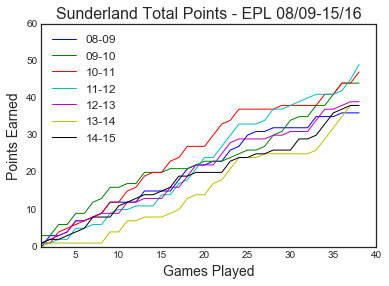

In [48]:
# Let's make a plot showing how points were earned over the course of all the seasons.
# For brevity's sake I'll simply call the seasons a,b,c,d,e,f.

a,b,c,d = twenty_8['total_points'], twenty_9['total_points'], \
          twenty_10['total_points'], twenty_11['total_points']
                                        
e,f,g = twenty_12['total_points'], twenty_13['total_points'], twenty_14['total_points']
    
plt.plot(a, label='08-09'), plt.plot(b, label='09-10'),
plt.plot(c, label='10-11'), plt.plot(d, label='11-12'),
plt.plot(e, label='12-13'), plt.plot(f, label='13-14'),
plt.plot(g, label='14-15')
plt.xlim([1,40])
plt.ylim([0,60])
plt.xlabel('Games Played', fontsize=14)
plt.ylabel('Points Earned', fontsize=14)
plt.title('Sunderland Total Points - EPL 08/09-15/16', fontsize=16)
plt.legend(loc=2)
plt.show() # Expand to full size otherwise the graph will be jumbled!

In [49]:
# Now let's make a plot showing points earned over the seasons.
# This time I'll do it over four stages on separate subplots.
# First I'll create a dataframe containing points earned over the four stages.
# Then I'll use the udf split_season to calculate points.
# As the 15-16 data is missing I'll add the data in manually.

def split_season(row):
    '''
    As 38 is not divisible by 4 I arbitaritly split the seasons as follows:
    1st = 10 games
    2nd = 9 games
    3rd = 10 games
    4th = 9 games
    '''
    
    points = []
    
    first = row[0:10].sum()
    second = row[10:19].sum()
    third = row[19:29].sum()
    fourth = row[29:].sum()
    
    points.append(first)
    points.append(second)
    points.append(third)
    points.append(fourth)        
    
    return points 

In [50]:
cols = ['1st','2nd','3rd','4th']
points = pd.DataFrame(columns=cols) 

twenty08_points = split_season(twenty_8['points'])
twenty09_points = split_season(twenty_9['points'])
twenty10_points = split_season(twenty_10['points'])
twenty11_points = split_season(twenty_11['points'])
twenty12_points = split_season(twenty_12['points'])
twenty13_points = split_season(twenty_13['points'])
twenty14_points = split_season(twenty_14['points'])
twenty15_points = [6,6,13,14] #manually calculated due to missing data

points=points.T
points[0] = twenty08_points
points[1] = twenty09_points
points[2] = twenty10_points
points[3] = twenty11_points
points[4] = twenty12_points
points[5] = twenty13_points
points[6] = twenty14_points
points[7] = twenty15_points
points=points.T

points = points.set_index(np.arange(2008,2016))
points

,1st,2nd,3rd,4th
2008,12,10,10,4
2009,16,6,9,13
2010,12,15,11,9
2011,10,11,16,12
2012,9,13,8,9
2013,4,10,11,13
2014,11,9,6,12
2015,6,6,13,14


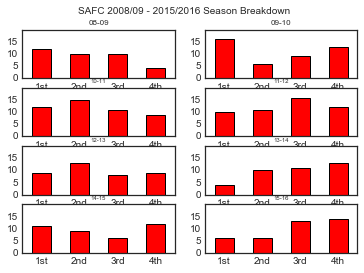

In [59]:
# Let's plot this out using bar charts.
# Setting up the subplot grid.

ax1 = plt.subplot2grid((4,2), (0,0), rowspan=1, colspan=1)
ax2 = plt.subplot2grid((4,2), (0,1), rowspan=1, colspan=1)
ax3 = plt.subplot2grid((4,2), (1,0), rowspan=1, colspan=1)
ax4 = plt.subplot2grid((4,2), (1,1), rowspan=1, colspan=1)
ax5 = plt.subplot2grid((4,2), (2,0), rowspan=1, colspan=1)
ax6 = plt.subplot2grid((4,2), (2,1), rowspan=1, colspan=1)
ax7 = plt.subplot2grid((4,2), (3,0), rowspan=1, colspan=1)
ax8 = plt.subplot2grid((4,2), (3,1), rowspan=1, colspan=1)

plt.suptitle('SAFC 2008/09 - 2015/2016 Season Breakdown',
             fontsize=10)

x = np.arange(1.25,5.25)
width = 1/2

row = points.iloc[0]
ax1.bar(x,row,width,color='r')
ax1.set_xticks(x + width/2.0)
ax1.set_xticklabels(('1st', '2nd', '3rd', '4th'))
ax1.set_ylim([0,20])
ax1.set_title('08-09', fontsize=8)
ax1.yaxis.set_major_locator(mticker.MaxNLocator(nbins=4, prune='upper'))

row = points.iloc[1]
ax2.bar(x,row,width,color='r')
ax2.set_xticks(x + width/2.0)
ax2.set_xticklabels(('1st', '2nd', '3rd', '4th'))
ax2.set_ylim([0,20])
ax2.set_title('09-10', fontsize=8)
ax2.yaxis.set_major_locator(mticker.MaxNLocator(nbins=4, prune='upper'))

row = points.iloc[2]
ax3.bar(x,row,width,color='r')
ax3.set_xticks(x + width/2.0)
ax3.set_xticklabels(('1st', '2nd', '3rd', '4th'))
ax3.set_ylim([0,20])
ax3.set_title('10-11', fontsize=6)
ax3.yaxis.set_major_locator(mticker.MaxNLocator(nbins=4, prune='upper'))

row = points.iloc[3]
ax4.bar(x,row,width,color='r')
ax4.set_xticks(x + width/2.0)
ax4.set_xticklabels(('1st', '2nd', '3rd', '4th'))
ax4.set_ylim([0,20])
ax4.set_title('11-12', fontsize=6)
ax4.yaxis.set_major_locator(mticker.MaxNLocator(nbins=4, prune='upper'))

row = points.iloc[4]
ax5.bar(x,row,width,color='r')
ax5.set_xticks(x + width/2.0)
ax5.set_xticklabels(('1st', '2nd', '3rd', '4th'))
ax5.set_ylim([0,20])
ax5.set_title('12-13', fontsize=6)
ax5.yaxis.set_major_locator(mticker.MaxNLocator(nbins=4, prune='upper'))

row = points.iloc[5]
ax6.bar(x,row,width,color='r')
ax6.set_xticks(x + width/2.0)
ax6.set_xticklabels(('1st', '2nd', '3rd', '4th'))
ax6.set_ylim([0,20])
ax6.set_title('13-14', fontsize=6)
ax6.yaxis.set_major_locator(mticker.MaxNLocator(nbins=4, prune='upper'))

row = points.iloc[6]
ax7.bar(x,row,width,color='r')
ax7.set_xticks(x + width/2.0)
ax7.set_xticklabels(('1st', '2nd', '3rd', '4th'))
ax7.set_ylim([0,20])
ax7.set_title('14-15', fontsize=6)
ax7.yaxis.set_major_locator(mticker.MaxNLocator(nbins=4, prune='upper'))

row = points.iloc[7] 
ax8.bar(x,row,width,color='r')
ax8.set_xticks(x + width/2.0)
ax8.set_xticklabels(('1st', '2nd', '3rd', '4th'))
ax8.set_ylim([0,20])
ax8.set_title('15-16', fontsize=6)
ax8.yaxis.set_major_locator(mticker.MaxNLocator(nbins=4, prune='upper'))

plt.show() # Expand to full size otherwise the graph will be jumbled!